<a href="https://colab.research.google.com/github/NINJAHATTORI004/ML-WORKSHOP/blob/main/yolo_you_only_look_once.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

object detection and image segmentation

algos: YOLO, SSD

yolo:you only look once
single network-processes entire image with a single neural network, dividing it into regions and predicting bounding boxes and probabilities simulaneously

trade-offs: while yolo is fast, it sometimes struggles with detecting small objects and may sacrifice accuracy for speed

Saving Screenshot 2024-11-26 115651.png to Screenshot 2024-11-26 115651.png


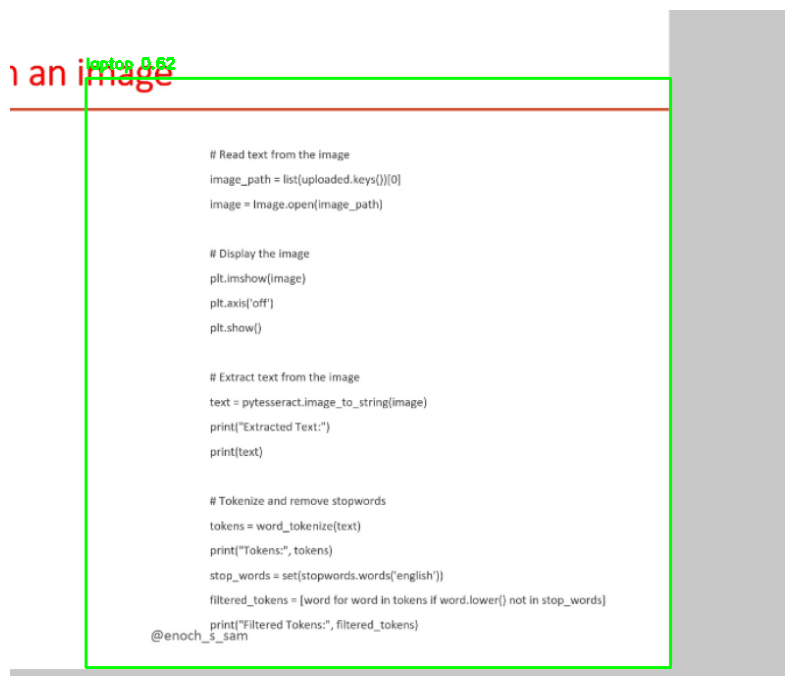

Object: laptop, Confidence: 0.62


In [ ]:
# Install necessary packages
!pip install opencv-python-headless

# Download YOLOv3 files (cfg and weights)
import os
import urllib.request

# URL for YOLOv3 weights and config files
yolo_url = "https://pjreddie.com/media/files/yolov3.weights"
cfg_url = "https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg"
coco_names_url = "https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names"

# Create folder for YOLOv3 files
if not os.path.exists('yolov3'):
    os.makedirs('yolov3')

# Download the YOLOv3 weights, config, and class names
urllib.request.urlretrieve(yolo_url, "yolov3/yolov3.weights")
urllib.request.urlretrieve(cfg_url, "yolov3/yolov3.cfg")
urllib.request.urlretrieve(coco_names_url, "yolov3/coco.names")

# Import OpenCV and other necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Upload image using Colab's file upload feature
uploaded = files.upload()

# Get the uploaded image filename
image_path = list(uploaded.keys())[0]  # Get the first uploaded file

# Load YOLO model
net = cv2.dnn.readNet("yolov3/yolov3.weights", "yolov3/yolov3.cfg")

# Load the class labels
with open("yolov3/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Get the layer names
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Read the uploaded image
image = cv2.imread(image_path)

# Prepare the image
height, width, channels = image.shape
blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

# Set the input to the model
net.setInput(blob)
outs = net.forward(output_layers)

# Initialize lists for detected bounding boxes, confidences, and class IDs
class_ids = []
confidences = []
boxes = []

# Process each detection
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        # Filter by confidence threshold
        if confidence > 0.5:
            # Get the bounding box coordinates
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Apply non-maximum suppression to eliminate redundant boxes
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# Initialize a list to store explanations for each detected object
explanations = []

# Draw the bounding boxes and labels
for i in range(len(boxes)):
    if i in indices:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        confidence = confidences[i]
        color = (0, 255, 0)  # Green for boxes

        # Draw the bounding box
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        # Add text (label and confidence score)
        cv2.putText(image, f"{label} {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Add the explanation (Object description)
        explanation = f"Object: {label}, Confidence: {confidence:.2f}"
        explanations.append(explanation)

# Display the image with bounding boxes and labels
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Display the explanations for the detected objects
for explanation in explanations:
    print(explanation)